# Tutorial: CTR Modeling on EKS

In this tutorial, we will use the classic [Multilayer Perception (MLP)](https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier) model to illustrate the workflow of deep learning model with Spark on Kubernetes. We'll see how to create a Jupyter notebook server Pod in an EKS cluster, and how to connect to the notebook server from local browser. Then inside the notebook, we will complete end-to-end feature engineering and Deep learning model training using [Spark MLlib](https://spark.apache.org/mllib/).

### Get current namespace

In [2]:
cat /var/run/secrets/kubernetes.io/serviceaccount/namespace

notebook

### Spark Docker
Please refer to the ```README``` on how to build the ```docker/spark/Dockerfile``` available in the GitHub repository.
<div class="alert alert-info">NOTE: Replace the docker image in the  ```spark.kubernetes.container.image``` below.</a></div>

### Start Spark Session

It's surprisingly fast to start a Spark cluster in EKS, you can start hundreds of executors in a few minutes. This is a great time saving feature to enable rapid data analysis. To make Spark available in your Jupyter notebook, you can use [findspark](https://pypi.org/project/findspark/) to initialize and import PySpark just as regular libraries. We'll be using the following library to create your Spark session with CPU, Memory, ShufflePartiton, etc. Kubernetes scheduler assigns the Spark executor containers on run on the EC2 instances in EKS cluster.

In [3]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

import socket
host_name = socket.gethostbyname(socket.gethostname())

def init_spark_session(num_executors):
    conf = SparkConf().setAppName('spark-on-k8s')
    conf.setMaster('k8s://https://kubernetes.default.svc:443')
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.kubernetes.allocation.batch.size", "40")
    conf.set("spark.executor.instances", num_executors)
    conf.set("spark.executor.cores", "4")
    conf.set("spark.executor.memory", "20G")
    conf.set("spark.driver.host", host_name)
    conf.set("spark.driver.memory", "20G")
    conf.set("spark.driver.maxResultSize", "18G")
    conf.set("spark.kubernetes.namespace", "notebook")
    conf.set("spark.kubernetes.container.image", "<REPLACE_WITH_SPARK_DOCKER_IMG>")
    conf.set("spark.kubernetes.container.image.pullPolicy", "IfNotPresent")
    conf.set("spark.kubernetes.pyspark.pythonVersion", "3")
    conf.set("spark.kubernetes.authenticate.driver.serviceAccountName", "spark")

    print("Starting spark session with num_executors: {}".format(num_executors))
    spark = SparkSession.builder.config(conf=conf).getOrCreate()
    return spark

### Let's start with a Spark session with a few executors

In [4]:
spark = init_spark_session(num_executors=2)

Starting spark session with num_executors: 2


In [5]:
spark

### Synthetic Data Generation

In Amazon, we deal with Petabyte scale datasets. For the purpose of the tutorial, we synthesized two sample datasets to illustrate the workflow rather than the scale. We will first load a small dataset with 90K rows to do feature engineering, model training etc. Later we'll use a larger dataset with around 1B rows for end to end execution.

In [6]:
import random
import pyspark.mllib.random as rnd
from pyspark.sql.functions import udf, array
from pyspark.sql.types import DoubleType

def get_random_udf(l):
    return udf(lambda: random.choice(l))

def get_click(numeric_features, coeff):
    col = len(coeff)
    products = sum([numeric_features[i] * (coeff[i] + random.random()) for i in range(col)])
    
    if products > col * random.random():
        return 1.0
    return 0.0

def get_click_udf(coeff):
    return udf(lambda features: get_click(features, coeff), DoubleType())

def get_synthetic_data(sc, num_rows=10, num_cols=10, num_partitions=1, seed=1):
    numeric_feature_names = list(map(lambda x: 'numeric_{}'.format(x), list(range(0, num_cols))))
    numeric_features_rdd = rnd.RandomRDDs.normalVectorRDD(sc, num_rows, num_cols, num_partitions, seed)
    numeric_features = numeric_features_rdd.map(lambda a : a.tolist()).toDF(numeric_feature_names)

    category_values = ['A'] * random.randint(1, 100) + ['B'] * random.randint(1, 100)
    features = numeric_features.withColumn('categoric_0', get_random_udf(category_values)())
    
    coeff = rnd.RandomRDDs.uniformRDD(sc, num_cols).collect()
    data = features.withColumn('click', get_click_udf(coeff)(array(numeric_feature_names)))

    return data

In [7]:
(num_rows, num_cols, num_partitions) = (100000, 10, 1)
df = get_synthetic_data(spark.sparkContext, num_rows, num_cols, num_partitions)
df.cache()

DataFrame[numeric_0: double, numeric_1: double, numeric_2: double, numeric_3: double, numeric_4: double, numeric_5: double, numeric_6: double, numeric_7: double, numeric_8: double, numeric_9: double, categoric_0: string, click: double]

In [8]:
df.printSchema()

root
 |-- numeric_0: double (nullable = true)
 |-- numeric_1: double (nullable = true)
 |-- numeric_2: double (nullable = true)
 |-- numeric_3: double (nullable = true)
 |-- numeric_4: double (nullable = true)
 |-- numeric_5: double (nullable = true)
 |-- numeric_6: double (nullable = true)
 |-- numeric_7: double (nullable = true)
 |-- numeric_8: double (nullable = true)
 |-- numeric_9: double (nullable = true)
 |-- categoric_0: string (nullable = true)
 |-- click: double (nullable = true)



### Feature Engineering

Machine Learning models expect numeric inputs in order to make predictions. But dataset usually comes in unstructured format. Since using the right numeric representation of features is crucial for the success of a machine learning model, we usually spend a lot of time understanding the data and applying appropriate transformations to the raw data to produce high quality features, this process is called feature engineering. We will cover a few common feature types and its associated feature engineering APIs in pyspark.

There are ```num_cols``` numerical features and 1 categorical feature in this raw data set, and click is the label column. We have named the features like numeric_n for simplicity of this tutorial. 

A quick exploratory data analysis (EDA) can show the ratio of click vs non-click impressions in this dataset.

In [10]:
print('click: {}'.format(df.filter(df.click == 1).count()))
print('non-click: {}'.format(df.filter(df.click != 1).count()))

click: 13171
non-click: 86829


#### Categorical Features

The most common type of data is categorical data that the values are discrete and form a finite set. A typical example is the size of shirts, the values include S, M, L, XL, etc. So feature engineering for categorical data is to apply transformations on the discrete values to produce distinct numeric values. Below is a simple example that how we can achieve that with StringIndexer from pyspark.

<AxesSubplot:>

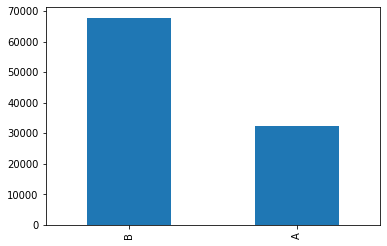

In [13]:
import pandas
pdf_categorical_feature = df.select('categoric_0').toPandas()

# Distribution of Categorical feature
pdf_categorical_feature['categoric_0'].value_counts().plot(kind='bar')

In [14]:
pdf_categorical_feature

,categoric_0
0,A
1,B
2,A
3,B
4,B
...,...
99995,B
99996,A
99997,B
99998,B


In [15]:
# Convert categorical feature into numerical feature
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer().setInputCol('categoric_0').setOutputCol('numeric_10')
indexer.fit(df).transform(df).limit(5).select('categoric_0', 'numeric_10').show()

numerical_features = indexer.fit(df).transform(df).drop('categoric_0').na.fill(0)

+-----------+----------+
|categoric_0|numeric_10|
+-----------+----------+
|          A|       1.0|
|          B|       0.0|
|          A|       1.0|
|          B|       0.0|
|          B|       0.0|
+-----------+----------+



NOTE: As we can see from the output, StringIndexer maps B in column categoric_0 to 1.0 in column numeric_10, and A to 0.0

#### Vectorization

We can then merge all the transformed values into a vector for further normalization and it can be processed by the learning algorithm easily. There is an API called VectorAssembler which can do this.

In [16]:
numerical_features

DataFrame[numeric_0: double, numeric_1: double, numeric_2: double, numeric_3: double, numeric_4: double, numeric_5: double, numeric_6: double, numeric_7: double, numeric_8: double, numeric_9: double, click: double, numeric_10: double]

In [17]:
# Feature Vectorization
from pyspark.ml.feature import VectorAssembler
feature_cols = numerical_features.columns
feature_cols.remove('click')

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
feature_vector = assembler.transform(numerical_features).drop(*feature_cols).withColumnRenamed('click', 'label')

In [19]:
# Features in sparse vector format
feature_vector.show(5, False)

+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                                   |
+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0.0  |[-0.7364417928926634,1.1537268112805235,0.46316657909752246,1.7794324881133858,0.35038251708418316,-1.2078422905234971,0.182557706990586,-0.28115411118907574,0.1794811259957898,-1.406603860191494,1.0]   |
|0.0  |[1.3494846050334237,-0.6572059487488587,-2.338727150900283,-0.6966792390268524,1.6356047759173402,-1.2537356749907436,0.057684896184203235,1.8656

#### Normalization

When dealing with numeric data, each column might have totally different range of the values. The normalization step can standardize the data and help following learning step. We will show how to perform normalization with StandardScaler from pyspark.

In [20]:
# Feature vector normalization
from pyspark.ml.feature import StandardScaler
scalerizer = StandardScaler().setInputCol('features').setOutputCol('normalized_features')
normalized_fv = scalerizer.fit(feature_vector).transform(feature_vector).drop('features').\
       withColumnRenamed('normalized_features', 'features')

In [21]:
normalized_fv.show(5, False)

+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                                                  |
+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0.0  |[-0.7362297602360367,1.1544578505037622,0.46225025038035605,1.7779990368819572,0.34794922147788515,-1.2069284034249674,0.18266651921793614,-0.2800539360944794,0.17976939613089873,-1.4072350282685373,2.1396805206549403]|
|0.0  |[1.3490960681407005,-0.6576223760361366,-2.334100213321664,-0.6961180175589041,1.6242

### Training Data Preparation

After feature engineering, you normally need to split the dataset to three non-overlapped sets for training, calibration and testing. You can either choose full scale training with all impressions or perform down-sampling strategy for training dataset to adjust the ratio of clicks vs non-clicks for more efficient training. You can also apply calibration to correct the overall bias after training. In this tutorial, given the size of dataset is small, we just do fair sampling on training/testing dataset and skip calibration step.

In [22]:
# Split into training and testing dataset
seed = 1234
splits = normalized_fv.randomSplit([0.7, 0.3], seed)
training_data = splits[0]
testing_data = splits[1]

### Model Training

<img src="model_architecture.png" alt="Model Architecture" width="1000"/>

Basic deep learning based CTR model follows the embedding & Multi-Layer-Perception (MLP) paradigm, where network layers are fed by an encoding layer. The encoding layer encodes the historical features (CTR & COEC, etc) and text features (e.g., Shopping Query), as well as the standard categorical features (e.g., Page Layout) using encoding techniques. Firstly, the large scale sparse feature inputs are mapped into low dimensional embedding vectors. Then the embedding vectors are transformed into fixed-length vectors via average pooling. Finally, the fixed-length feature vectors are concatenated together to fed into MLP. In this tutorial, we build a basic MLP model for CTR prediction via MultilayerPerceptronClassifier in Spark ML library. The raw feature set has 11 numerical features and 1 categorical feature with size of around 90K row, hence we only define one single hidden layer with 25 nodes. And the output dimensions of the MLP layers are 11, 25 and 2, where nodes in intermediate layers use sigmoid function and nodes in the output layer use softmax function.

In [23]:
# MLP based CTR model
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [11, 25, 2]
trainer = MultilayerPerceptronClassifier(maxIter=10, layers=layers, blockSize=128, seed=seed)

mlp_model = trainer.fit(training_data)

result = mlp_model.transform(testing_data)

In [25]:
result.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|[-4.8084804095445...|[2.41533275797333...|[0.99486591490757...|       0.0|
|  0.0|[-4.4206894066630...|[3.79828745987186...|[0.99950563650799...|       0.0|
|  0.0|[-4.2755452027141...|[3.39402550539004...|[0.99923093120135...|       0.0|
|  0.0|[-3.6498486759062...|[3.36304212645181...|[0.99827470856746...|       0.0|
|  0.0|[-3.4651340845658...|[1.21855065082685...|[0.94745955128086...|       0.0|
|  0.0|[-3.4618340266007...|[3.30358497922916...|[0.99896201545287...|       0.0|
|  0.0|[-3.4337473953628...|[2.1587826820064,...|[0.99277012251603...|       0.0|
|  0.0|[-3.4073895913747...|[1.69691098614294...|[0.98731895525694...|       0.0|
|  0.0|[-3.3998364836530...|[2.75175577104954...|[0.99789743752986...|       0.0|
|  0.0|[-3.37611

### Model Evaluation

We will use log loss and AUC to evaluate the quality of model. Log loss is a standard evaluation criterion for events such as click-through rate prediction. AUC is short for Area Under ROC curve, where the ROC curve shows the ratio of false positive rate (FPR) and true positive rate (TPR) when we liberalize the threshold to give positive prediction.

In [26]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType

get_probability_udf = udf(lambda l: float(l[1]), DoubleType())
probability_label = result.select(
    get_probability_udf('probability').alias('probability'), 'label').withColumn('label', col('label').cast('double'))

from pyspark.mllib.evaluation import BinaryClassificationMetrics

metrics = BinaryClassificationMetrics(probability_label.rdd.map(tuple))

In [28]:
metrics

#### Area Under ROC
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters: True Positive Rate (TPR), and False Positive Rate (FPR).

In [34]:
import matplotlib.pyplot as plt

rdd = getattr(metrics._java_model, 'roc')().toJavaRDD()

points = []
for row in rdd.collect():
    points += [(float(row._1()), float(row._2()))]

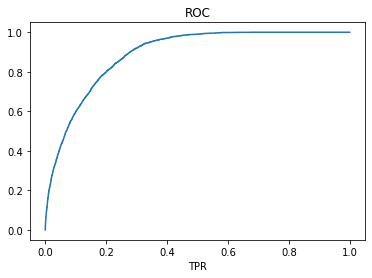

In [35]:
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC')
plt.xlabel('FPR')
plt.xlabel('TPR')
plt.plot(x_val, y_val)

In [36]:
print(f'Area under ROC = %s' % metrics.areaUnderROC)

Area under ROC = 0.8894075220608592


#### Log Loss
Log Loss is the most important classification metric based on probabilities. For a given problem, a lower log-loss value means better predictions.

In [37]:
from pyspark.sql.functions import when, log, mean

log_loss_df = probability_label.select(when(probability_label['label'] == 1, -log(probability_label['probability'])).\
                                       otherwise(-log(1 - probability_label['probability'])).alias('log_loss'))

log_loss = log_loss_df.agg(mean('log_loss').alias('l_l')).collect()[0]['l_l']
print(f'Log Loss = %s' % log_loss)

Log Loss = 0.2588519640114422


#### CTR Distribution

<AxesSubplot:ylabel='Frequency'>

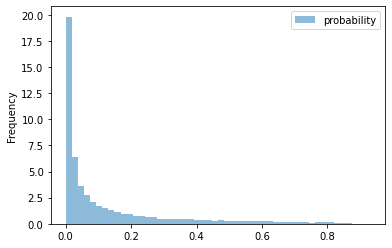

In [41]:
probabilities = probability_label.select('probability').toPandas()
probabilities.plot.hist(bins=50, alpha=0.5, density=1)

### Now let's increase the executors to work with big data

<div class="alert alert-info">NOTE: After exploring on the small dataset a little bit, we are ready to go through the same feature engineering process again on the 1B dataset and prepare data for model training. And our solution works well on data with such size.</div>

In [42]:
spark.stop()
spark = init_spark_session(num_executors=20)

Starting spark session with num_executors: 20


In [44]:
spark

### Feature Engineering on 1B Data

In [45]:
(num_rows, num_cols, num_partitions) = (1000000000, 10, 1000)
df = get_synthetic_data(spark.sparkContext, num_rows, num_cols, num_partitions)
df.printSchema()
df.cache()

print('click: {}'.format(df.filter(df.click == 1).count()))
print('non-click: {}'.format(df.filter(df.click != 1).count()))

# Convert categorical feature into numerical feature
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer().setInputCol('categoric_0').setOutputCol('numeric_10')
numerical_features = indexer.fit(df).transform(df).drop('categoric_0').na.fill(0)

# Feature Vectorization
from pyspark.ml.feature import VectorAssembler
feature_cols = numerical_features.columns
feature_cols.remove('click')

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
feature_vector = assembler.transform(numerical_features).drop(*feature_cols).withColumnRenamed('click', 'label')

# Feature vector normalization
from pyspark.ml.feature import StandardScaler
scalerizer = StandardScaler().setInputCol('features').setOutputCol('normalized_features')
normalized_fv = scalerizer.fit(feature_vector).transform(feature_vector).drop('features').withColumnRenamed('normalized_features', 'features')

root
 |-- numeric_0: double (nullable = true)
 |-- numeric_1: double (nullable = true)
 |-- numeric_2: double (nullable = true)
 |-- numeric_3: double (nullable = true)
 |-- numeric_4: double (nullable = true)
 |-- numeric_5: double (nullable = true)
 |-- numeric_6: double (nullable = true)
 |-- numeric_7: double (nullable = true)
 |-- numeric_8: double (nullable = true)
 |-- numeric_9: double (nullable = true)
 |-- categoric_0: string (nullable = true)
 |-- click: double (nullable = true)

click: 132186312
non-click: 867813688


In [46]:
# Split into training and testing dataset
seed = 1234
splits = normalized_fv.randomSplit([0.7, 0.3], seed)
training_data = splits[0]
testing_data = splits[1]

### Model Training

In [47]:
# MLP based CTR model
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [11, 25, 2]
trainer = MultilayerPerceptronClassifier(maxIter=10, layers=layers, blockSize=128, seed=seed)

mlp_model = trainer.fit(training_data)

result = mlp_model.transform(testing_data)

In [48]:
result.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|[-5.2054159344268...|[3.90495310895609...|[0.99942834311940...|       0.0|
|  0.0|[-4.8098127287259...|[2.78039617778141...|[0.99734271399049...|       0.0|
|  0.0|[-4.7243289547889...|[2.95249354799626...|[0.99764477084954...|       0.0|
|  0.0|[-4.2566361281857...|[1.96090998483072...|[0.98984829677926...|       0.0|
|  0.0|[-4.0726733061780...|[3.82729458190679...|[0.99979734687489...|       0.0|
|  0.0|[-4.0575591987422...|[3.17354130022613...|[0.99889681137230...|       0.0|
|  0.0|[-4.0254455078853...|[3.3412912065155,...|[0.99950807331617...|       0.0|
|  0.0|[-4.0202463359206...|[1.55861504449304...|[0.98948487537028...|       0.0|
|  0.0|[-3.9806532284056...|[2.73937382792825...|[0.99853558976682...|       0.0|
|  0.0|[-3.95670

### Model Evaluation

In [49]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType

get_probability_udf = udf(lambda l: float(l[1]), DoubleType())
probability_label = result.select(
    get_probability_udf('probability').alias('probability'), 'label').withColumn('label', col('label').cast('double'))

from pyspark.mllib.evaluation import BinaryClassificationMetrics

metrics = BinaryClassificationMetrics(probability_label.rdd.map(tuple))

In [50]:
metrics

#### Area Under ROC
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters: True Positive Rate (TPR), and False Positive Rate (FPR).

In [51]:
print(f'Area under ROC = %s' % metrics.areaUnderROC)

Area under ROC = 0.891779317357863


#### Log Loss
Log Loss is the most important classification metric based on probabilities. For a given problem, a lower log-loss value means better predictions.

In [52]:
from pyspark.sql.functions import when, log, mean

log_loss_df = probability_label.select(when(probability_label['label'] == 1, -log(probability_label['probability'])).\
                                       otherwise(-log(1 - probability_label['probability'])).alias('log_loss'))

log_loss = log_loss_df.agg(mean('log_loss').alias('l_l')).collect()[0]['l_l']
print(f'Log Loss = %s' % log_loss)

Log Loss = 0.2587065412441612


### Cleanup Resource

After this tutorial, you can release Spark executors and give resource back to Kubernetes by just calling Spark's stop API.

In [ ]:
spark.stop()